<a href="https://colab.research.google.com/github/carloshernangarrido/structural-health-monitoring/blob/main/time_domain_damage_detection_stat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damage identification in beams using time-domain data extracted from video burst-records of free vibrations and statistical tools

# Packages and modules

In [1]:
%reset -f
# Packages installation
!pip install --index-url https://test.pypi.org/simple/ py-shm-damage==1.0.6 --extra-index-url https://pypi.org/simple

# Modules import
from shmdamage import hsmr
import numpy as np
import scipy.io
from scipy.signal import butter, lfilter

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from google.colab import drive
drive.mount('/content/drive')
import os
from matplotlib.backends.backend_pdf import pdfRepr


Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple
  Preparing metadata (setup.py) ... done
  Created wheel for py-shm-damage: filename=py_shm_damage-1.0.6-py3-none-any.whl size=2843 sha256=8aeeb0f8f4fbea2e7d4bdd0556d23ba352547b83b1a5152e7001ff06c5b2be90
  Stored in directory: /root/.cache/pip/wheels/ef/71/7c/5a96a36b79e5226dbd297a9cb437e74b5b663bede610bcaad1
Successfully built py-shm-damage
Mounted at /content/drive


# Input parameters

## Classes

In [2]:
class InputParameters: 
  '''
  Description
  ----------
  An object of Input Parameters for damage detection.

  Atributes
  ----------
  files : list of str
    List containing the file names where displacements are stored.
  h_d : int
    Radius of apparent damage extent (in points).
  L_d : int
    Apparent length of damage (in points).
  L_ch : int
    Characteristic length of damage for median filter (in points).
  h_s_mm : float
    Cross-section height in mm.
  h_s_px : float
    Cross-section height in px.
  scale_mm_px : float
    Scale in mm per pixel.   
  fix_end_loc_px : int    
    Location of the fix end in px.
  crack_locs_mm : list[float]
    A list of 3 integers specifying the crack locations in mm from fix end.
  crack_locs_px : list[int]
    A list of 3 integers specifying the crack locations in px from fix end.    
  '''
  def __init__(self, files=None, h_d: int=0, 
               h_s_mm: float=0.0, h_s_px: float=0.0, 
               crack_locs_mm: list=3*[0.0], fix_end_loc_px: int=0):  
    if files is None:
      self.files = []
    self.files = files
    self.h_d = h_d
    self.L_d = 2*self.h_d    
    self.L_ch = 3*self.L_d
    self.h_s_mm = h_s_mm
    self.h_s_px = h_s_px
    self.crack_locs_mm = crack_locs_mm
    if h_s_px !=0 and h_s_mm != 0:
      self.scale_mm_px = h_s_mm/h_s_px
      self.crack_locs_px = []
      for loc_mm in self.crack_locs_mm:
        self.crack_locs_px.append(fix_end_loc_px - loc_mm/self.scale_mm_px)
    else:
      self.scale_mm_px = None


class TimeHistory:
  '''
  Description
  ----------
  An object of time histories.

  Attributes
  ----------
  file_name : str
    File name including full path
  _name : str
    Name extracted from file_name
  S : dict
    This dict initializes the object. It must be a dictionary returned by 
    scipy.io.loadmat(input_file_name)
  x : ndarray(n_points, 1)
    positions of points along the beam axis
  t : ndarray(1, n_time_instants)
    time along the time  
  initial_time : float
    minimum time considered in s
  final_time : float
    maximum time considered in s
  cutt_off_freq : float
    cutt off frequency for a first order butterworth low pass filter. If None, 
    no filter is applied.
  D_ : ndarray(n_points, n_time_instants)
    matrix of transverse static displacements of the beam
  D : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic displacements of the beam
  S_ : ndarray(n_points, n_time_instants)
    matrix of transverse static slopes of the beam
  S : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic slopes of the beam
  C_ : ndarray(n_points, n_time_instants)
    matrix of transverse static curvatures of the beam        
  C : ndarray(n_points, n_time_instants)
    matrix of transverse dynamic curvatures of the beam        
  V : ndarray(n_points, n_time_instants)
      matrix of transverse velocities of the beam    
  A : ndarray(n_points, n_time_instants)
    matrix of transverse accelerations of the beam
  '''  
  def __init__(self, S, file_name=None, 
               initial_time=None, final_time=None, cut_off_freq=None):
    self.file_name = file_name
    if self.file_name is None:
      self._name = None
    else:
      head, tail = os.path.split(self.file_name)
      self._name = tail[0:-4]

    # Extraction of static displacements
    self.initial_time = initial_time
    self.final_time = final_time
    self.cut_off_freq = cut_off_freq
    self.x = np.array(S['displacements']['x'][0][0], dtype=np.float64) 
    self.D_ = np.array(S['displacements']['D'][0][0], dtype=np.float64) 
    self.t = np.array(S['displacements']['t'][0][0], dtype=np.float64)

    # Low-pass Filtering of static displacements
    if self.cut_off_freq != 0:
      b, a = butter(N=1, Wn=self.cut_off_freq, 
                    fs=1/np.mean(np.diff(self.t)), btype='low', analog=False)
      self.D_ = lfilter(b, a, self.D_)
      print(f"fs = {1/np.mean(np.diff(self.t))} Hz, fc = {self.cut_off_freq}")

    # Time cropping
    print(f"time goes from {self.t[0, 0]} to {self.t[0, -1]} s")
    if self.initial_time is None:
      self._initial_time_ind = 0
    else:  
      self._initial_time_ind = np.argmin(np.abs(self.t - self.initial_time))
    
    if self.final_time is None:
      self._final_time_ind = self.D_.shape[1]
    else:
      self._final_time_ind = np.argmin(np.abs(self.t - self.final_time))
    
    self.D_ = self.D_[:,self._initial_time_ind:self._final_time_ind]
    self.t = self.t[:,self._initial_time_ind:self._final_time_ind]
   
    self.n_points = self.D_.shape[0]
    self.n_time_instants = self.D_.shape[1]

    # Initial calculation of slopes and curvatures
    self.S_ = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    self.C_ = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    for j in range(self.n_time_instants):
      self.S_[:, j] = (np.diff(self.D_[:, j], append=0) \
                      / np.diff(self.x[:, 0], append=np.nan))
      self.C_[:, j] = (np.diff(self.S_[:, j], prepend=0) \
                      / np.diff(self.x[:, 0], prepend=np.nan))      
      self.S_[-1, j] = self.S_[-2, j]
      self.C_[0, j] = self.C_[1, j]
      self.C_[-1, j] = self.C_[-2, j]
 
    # Retain dynamic displacements, slopes and curvatures
    self.D = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    self.S = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    self.C = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    for i in range(self.n_points):
      self.D[i, :] = self.D_[i, :] - np.mean(self.D_[i, :], axis=0)
      self.S[i, :] = self.S_[i, :] - np.mean(self.S_[i, :], axis=0)
      self.C[i, :] = self.C_[i, :] - np.mean(self.C_[i, :], axis=0)

    # Calculation of velocities and accelerations
    self.V = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)
    self.A = np.zeros((self.n_points, self.n_time_instants), dtype=np.float64)    
    for i in range(self.n_points):
      self.V[i, :] = np.diff(self.D[i,:], append=0) / \
       np.diff(self.t[0,:], append=np.nan)
      self.A[i, :] = np.diff(self.V[i,:], prepend=0) / \
       np.diff(self.t[0,:], prepend=np.nan)  
      self.V[i, -1] = self.V[i, -2]
      self.A[i, 0] = self.A[i, 1]
      self.A[i, -1] = self.A[i, -2]       



## Loading

In [3]:
time_scale = 60/1000
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain/get displacements/60dofs'
files = ['00_00_00_run1.mat', 
         '05_00_00_run1.mat', 
         '10_00_00_run1.mat', 
         '13_00_00_run1.mat', 
         '13_05_00_run1.mat', 
         '13_05_05_run1.mat', 
         '13_10_05_run1.mat', 
         '13_10_11_run1.mat']
ip = InputParameters(
    files=[os.path.join(path, files[i]) for i in range(len(files))], 
    h_d=2, h_s_px=43, h_s_mm=25.4, crack_locs_mm=[100, 210, 297], fix_end_loc_px=1223)
ths = [TimeHistory(scipy.io.loadmat(file_name), file_name=file_name, 
                   initial_time=2.5, final_time=4.5, cut_off_freq=1) 
# actual_cut_off_freq = 1 * 1000/60, since actual_fps = 1000, record_fps = 60
for file_name in ip.files]
print(ip.crack_locs_px)



fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.96834388537154 s
fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.96834388537154 s
fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.96834388537154 s
fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.96834388537154 s
fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.985004998333885 s
fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.96834388537154 s
fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.985004998333885 s
fs = 60.02000000000001 Hz, fc = 1
time goes from 0.0 to 44.985004998333885 s
[1053.708661417323, 867.488188976378, 720.2047244094488]


fs = 60.02000000000001 Hz, fc = 30
time goes from 0.0 to 44.96834388537154 s
fs = 60.02000000000001 Hz, fc = 30
time goes from 0.0 to 44.96834388537154 s


<function matplotlib.pyplot.show(close=None, block=None)>

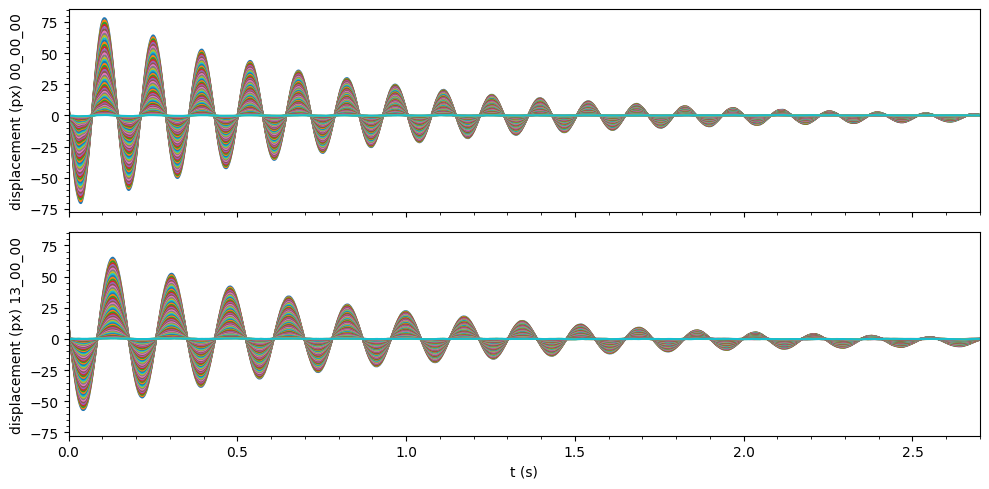

In [4]:
# Example
fig_size = (10, 5)
file_name_healthy = os.path.join(path, '00_00_00_run1.mat')
th_healthy = TimeHistory(scipy.io.loadmat(file_name_healthy), file_name=file_name_healthy, 
                         initial_time=None, final_time=None, cut_off_freq=30)
file_name_damaged = os.path.join(path, '13_00_00_run1.mat')
th_damaged = TimeHistory(scipy.io.loadmat(file_name_damaged), file_name=file_name_damaged, 
                         initial_time=None, final_time=None, cut_off_freq=30)

fig_example, ax_example = plt.subplots(2, 1, figsize=fig_size, 
                                       tight_layout=True, 
                                       sharey='col', sharex='col')
plt.minorticks_on()
ax_example[0].plot(time_scale*th_healthy.t.T, -th_healthy.D.T);
ax_example[0].set_ylabel('displacement (px) 00_00_00')
ax_example[0].set_xlim((0, 2.7))

ax_example[1].plot(time_scale*th_damaged.t.T, -th_damaged.D.T);
ax_example[1].set_ylabel('displacement (px) 13_00_00')
ax_example[1].set_xlabel('t (s)')
plt.savefig(os.path.join(path, 'time_history_example.pdf'), bbox_inches='tight')
plt.show

### Plots

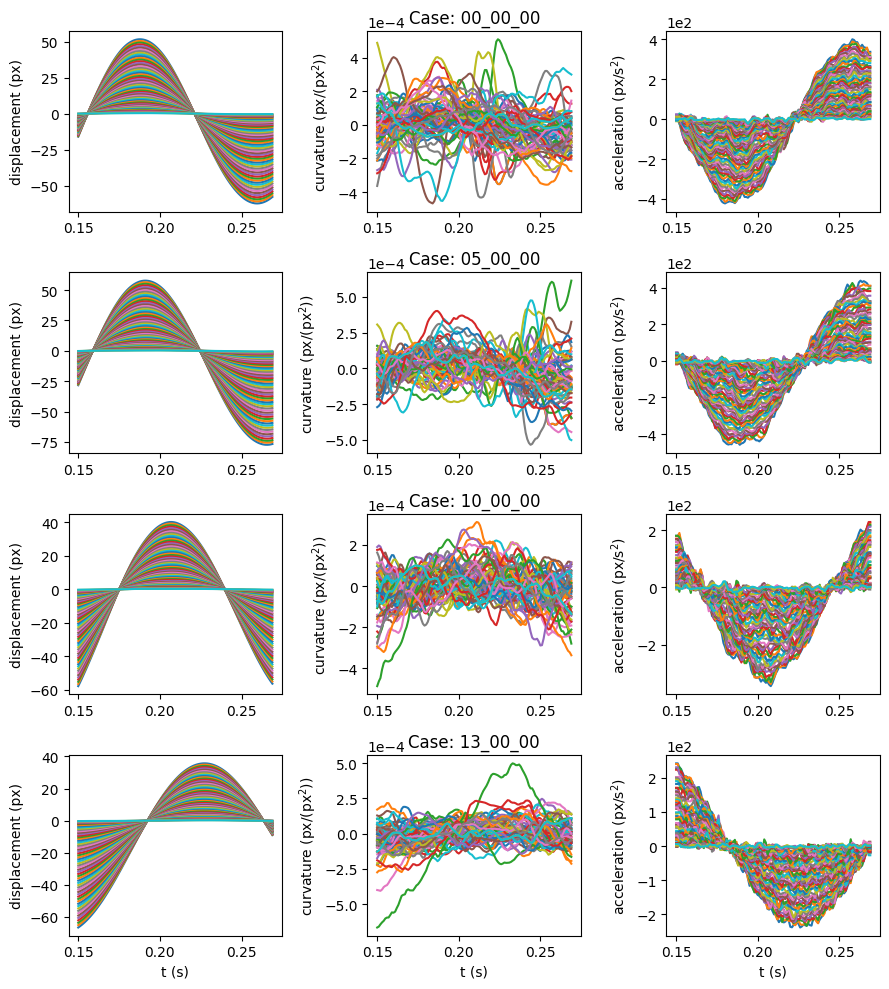

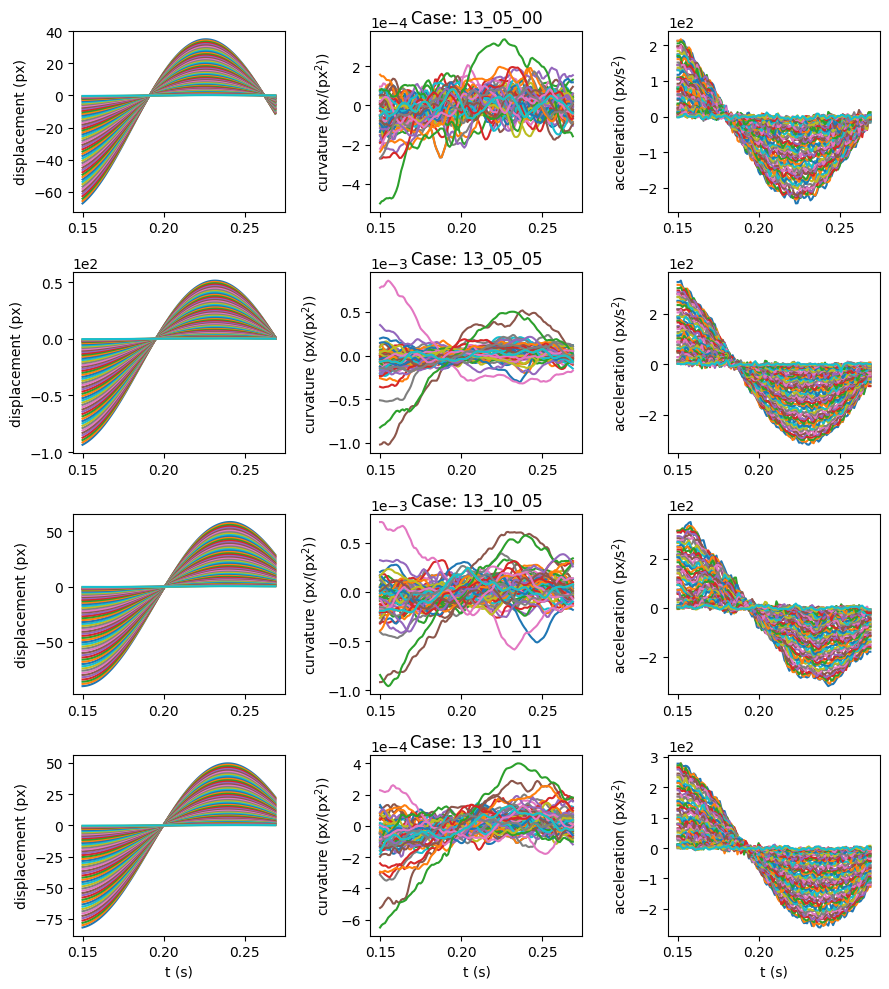

In [5]:
fig_size = (9, 10)
figs = []
for i_fig in [0, 1]:
  fig, ax = plt.subplots(len(ths)//2, 3, figsize=fig_size, tight_layout=True)
  figs.append(fig)
  for i, th in enumerate(ths[0+(len(ths)//2)*(i_fig):(len(ths)//2)*(i_fig+1)]):
    ax[i, 1].set_title(f'Case: {th._name[0:-5]}')
    ax[i, 0].plot(time_scale*th.t.T, th.D.T)
    ax[i, 0].set_ylabel('displacement (px)')  
    ax[i, 0].ticklabel_format(axis='y', scilimits=[-2, 2])
    ax[i, 1].plot(time_scale*th.t.T, th.C.T)
    ax[i, 1].set_ylabel('curvature (px/(px$^2$))')
    ax[i, 1].ticklabel_format(axis='y', scilimits=[-2, 2])
    ax[i, 2].plot(time_scale*th.t.T, th.A.T)
    ax[i, 2].set_ylabel('acceleration (px/s$^2$)')  
    ax[i, 2].ticklabel_format(axis='y', scilimits=[-2, 2])
  ax[i, 0].set_xlabel('t (s)')
  ax[i, 1].set_xlabel('t (s)')
  ax[i, 2].set_xlabel('t (s)')  
  plt.savefig(os.path.join(path, f'TH_{i_fig+1}.pdf'), bbox_inches='tight')
  plt.show

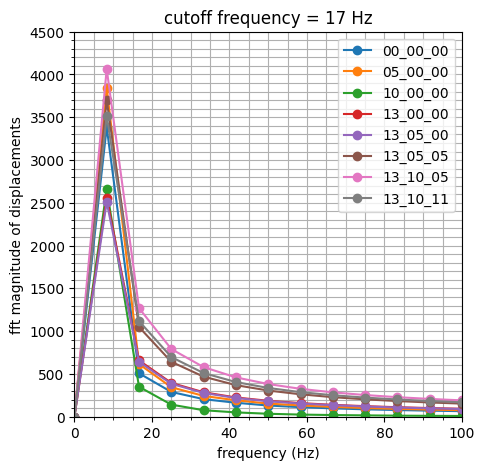

In [6]:
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
fig, axx = plt.subplots(1,1, figsize=[5,5]) 

for th in ths:
  t = time_scale*th.t.T.reshape((-1))
  s = th.D[0,:].T
  # plt.minorticks_on()
  # plt.plot(t, s)
  # plt.show()

  sp = fftshift(fft(s))
  freq = fftshift(fftfreq(t.shape[-1])/(t[1]-t[0]))
  plt.minorticks_on()
  axx.grid(True, which='both')
  axx.plot(freq, np.abs(sp), marker='o', label=th._name[0:-5])
  axx.set_xlim([0, 100])
  axx.set_xlabel('frequency (Hz)')
  axx.set_ylabel('fft magnitude of displacements')
  axx.set_title(f"cutoff frequency = {round(th.cut_off_freq / time_scale)} Hz")
  axx.set_ylim([0, 4500])
axx.legend()
plt.show()

# Pre-processing

## Detect the time instant of minimum and maximum rms curvature

### Extraction of intantaneous curvatures and accelerations

In [7]:
neg_pos = -1
max_curv_lim = 0
cases = {}
for th in ths:
  rms_accel = np.sqrt(np.mean(th.A**2, axis=0))
  rms_curv = np.sqrt(np.mean(th.C**2, axis=0))
  mean_curv = np.mean(th.C, axis=0)
  abs_mean_curv = np.abs(np.mean(th.C, axis=0))
  rms_disp = np.sqrt(np.mean(th.D**2, axis=0))
  peak_curv = np.max(np.abs(th.C), axis=0)
  peak_disp = np.max(np.abs(th.D), axis=0)
  max_curv_ind, min_curv_ind = np.argmax(rms_disp), np.argmin(rms_disp)
  if np.max(np.max(np.abs(th.C))) > max_curv_lim:
    max_curv_lim = np.max(np.max(np.abs(th.C)))
  cases[th._name] = \
    {'min_curv': {'x': th.x, 'C': th.C[:,min_curv_ind], 
                  'S': th.S[:,min_curv_ind], 'D': th.D[:,min_curv_ind], 
                  'D_': th.D_[:,min_curv_ind], 'A': th.A[:,min_curv_ind]},
     'min_curv_rms': rms_curv[min_curv_ind],
     'min_curv_disp_rms': np.sqrt(np.mean(th.D[:,min_curv_ind]**2, axis=0)),
     'max_curv': {'x': th.x, 
                  'C': th.C[:,max_curv_ind],
                  'logC': np.log(neg_pos*th.C[:,max_curv_ind]), 
                  'S': th.S[:,max_curv_ind], 
                  'D': th.D[:,max_curv_ind], 
                  'D_': th.D_[:,max_curv_ind], 
                  'A': th.A[:,max_curv_ind]},
     'max_curv_rms': rms_curv[max_curv_ind],
     'max_curv_disp_rms': np.sqrt(np.mean(th.D[:,max_curv_ind]**2, axis=0)),
     'max_curv_median': {'x': th.x, 'C': 
                         scipy.ndimage.median_filter(th.C[:,max_curv_ind], 
                                                     size=ip.L_ch, 
                                                     mode='mirror')}}


<ipython-input-7-72cb75e3de44>:23: RuntimeWarning: invalid value encountered in log
  'logC': np.log(neg_pos*th.C[:,max_curv_ind]),


### Plot curvatures and accelerations

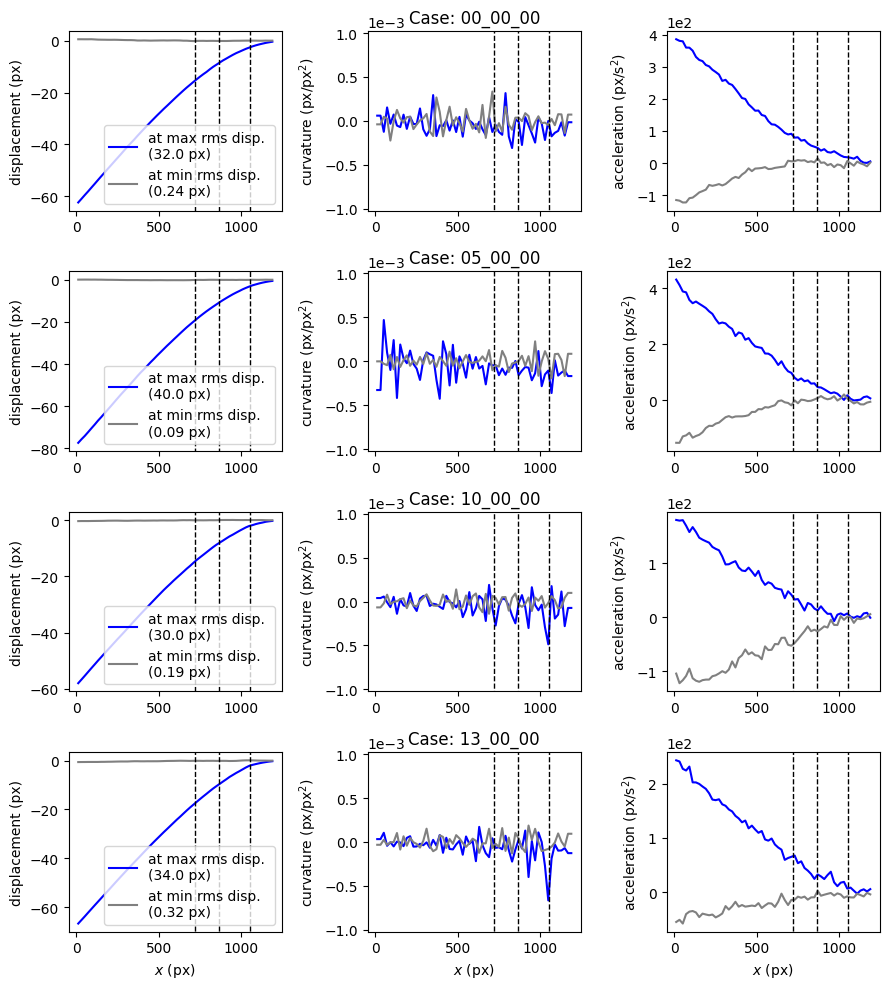

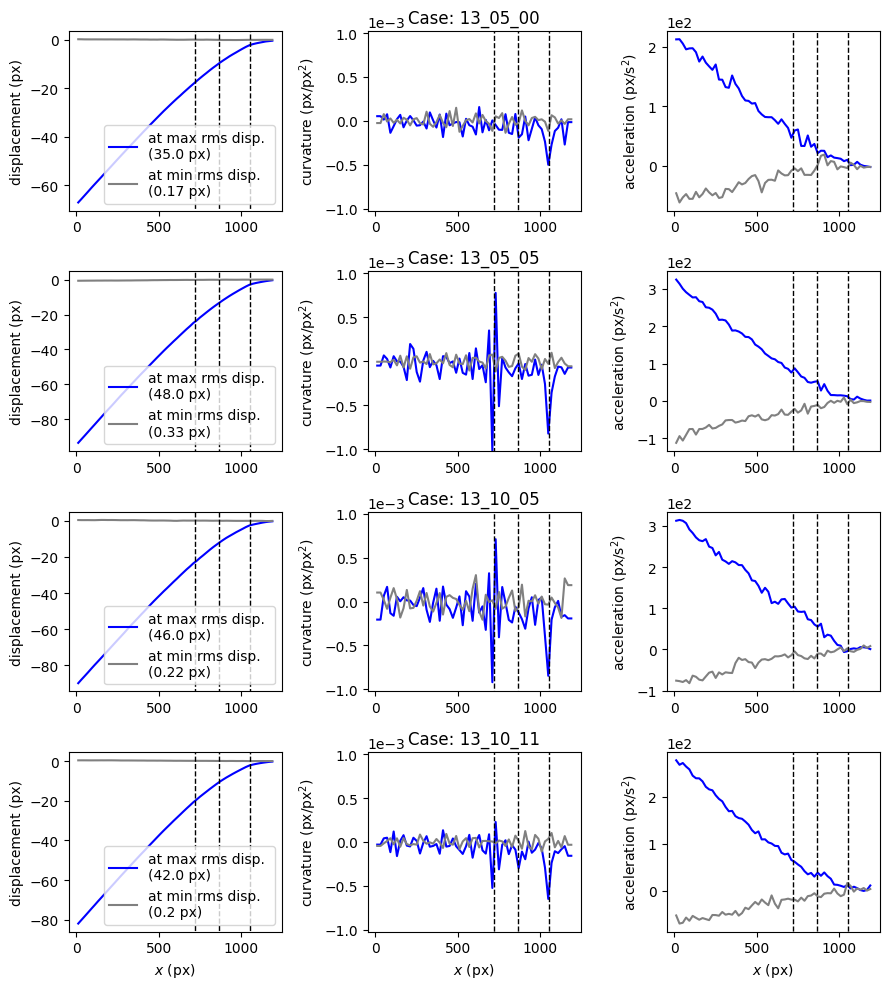

In [8]:
import math
fig_size = (9, 10)
figs = []
for i_fig in [0, 1]:
  fig, axs = plt.subplots(len(cases)//2, 3, figsize=fig_size, tight_layout=True)
  figs.append(fig)  
  for i, key in enumerate(list(cases.keys())[0+(len(cases)//2)*(i_fig):(len(cases)//2)*(i_fig+1)]):
    axs[i, 1].set_title(f"Case: {key[0:-5]}")
    axs[i, 0].set_ylabel('displacement (px)') 
    axs[i, 0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['D'],
                color='blue', label=f'at max rms disp. \n({round(cases[key]["max_curv_disp_rms"], 2 - int(math.floor(math.log10(abs(cases[key]["max_curv_disp_rms"])))) - 1)} px)')
    axs[i, 0].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['D'],
                color='gray', label=f'at min rms disp. \n({round(cases[key]["min_curv_disp_rms"], 2 - int(math.floor(math.log10(abs(cases[key]["min_curv_disp_rms"])))) - 1)} px)')
    axs[i, 0].ticklabel_format(axis='y', scilimits=[-2, 2]) 
    _ = axs[i, 0].get_ylim()
    for loc_px in ip.crack_locs_px:
      axs[i, 0].plot([loc_px, loc_px], [-100, 100],
                color='black', linewidth=1, linestyle='--', label=None)
    axs[i, 0].set_ylim(_)

    axs[i, 1].set_ylabel('curvature (px/px$^2$)')
    axs[i, 1].set_ylim((-max_curv_lim, max_curv_lim))
    axs[i, 1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C'],
                color='blue', label='at max rms disp.')
    axs[i, 1].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['C'],
                color='gray', label='at min rms disp.')  
    axs[i, 1].ticklabel_format(axis='y', scilimits=[-2, 2]) 
    _ = axs[i, 1].get_ylim()
    for loc_px in ip.crack_locs_px:
      axs[i, 1].plot([loc_px, loc_px], [-100, 100],
                color='black', linewidth=1, linestyle='--', label=None)
    axs[i, 1].set_ylim(_)

    axs[i, 2].set_ylabel('acceleration (px/s$^2$)') 
    axs[i, 2].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['A'],
                color='blue', label='at max rms')
    axs[i, 2].plot(cases[key]['min_curv']['x'], cases[key]['min_curv']['A'],
                color='gray', label='at min rms curv.')    
    axs[i, 2].ticklabel_format(axis='y', scilimits=[-2, 2]) 
    _ = axs[i, 2].get_ylim()
    for loc_px in ip.crack_locs_px:
      axs[i, 2].plot([loc_px, loc_px], [-1000, 1000],
                color='black', linewidth=1, linestyle='--', label=None)
    axs[i, 2].set_ylim(_)

    axs[i, 0].legend() 
  axs[i, 0].set_xlabel('$x$ (px)') 
  axs[i, 1].set_xlabel('$x$ (px)')
  axs[i, 2].set_xlabel('$x$ (px)')
  plt.savefig(os.path.join(path, f'DCA_{i_fig+1}.pdf'), bbox_inches='tight')
  plt.show()

## Sinthesys of healthy structure model response, using meassured curvature

In [9]:
neg_pos = -1
for key in cases.keys():
  c_h, m_, m, res_x = hsmr.synthesis(
      c=cases[key]['max_curv']['C'], 
      q=cases[key]['max_curv']['A'], dyn_stiff_initial_guess=10, dyn_stiff_min=1, m_0_max=0)
  # bending moment with null integration constants
  cases[key]['max_curv'].update({'M_': m_})
  # bending moment with apropriate integration constants and dynamic stiffness
  cases[key]['max_curv'].update({'M': m})  
  # healthy curvature
  cases[key]['max_curv'].update({'C_h': c_h})

  # construction of noisy healthy curvature
  cases[key]['max_curv'].update({'C_h_noisy': cases[key]['max_curv']['C_h']
                                 + cases[key]['min_curv']['C']}) 

## Generation of actual damage reference

In [10]:
for key in cases.keys():
  crack_depths_mm = 3*[0]
  crack_depths_mm[0] = float(key[0:2])
  crack_depths_mm[1] = float(key[3:5])
  crack_depths_mm[2] = float(key[6:8])
  x = ths[0].x
  H_EI_actual = np.ones(len(x))
  print('')
  for crack_loc_px, crack_depth_mm in zip(ip.crack_locs_px, crack_depths_mm):
    crack_loc_ind = np.argmin(abs(x - crack_loc_px))
    H_EI_d = (1 - (crack_depth_mm/ip.h_s_mm))**3
    print(H_EI_d)
    h_d_px = ip.h_d *(x[1]-x[0])
    slope = (1-H_EI_d)/h_d_px
    for i in range(crack_loc_ind, crack_loc_ind+ip.h_d):
      H_EI_actual[i] = H_EI_d + slope*(x[i] - crack_loc_px)
    for i in range(crack_loc_ind-ip.h_d+1, crack_loc_ind):
      H_EI_actual[i] = H_EI_d - slope*(x[i] - crack_loc_px)      
    H_EI_actual[crack_loc_ind] = H_EI_d
  cases[key].update({'H_EI': {'x': cases[key]['max_curv']['x'],
                              'H_EI_actual': H_EI_actual}})
  


1.0
1.0
1.0

0.5180710833862613
1.0
1.0

0.22287482370240336
1.0
1.0

0.11634933506087486
1.0
1.0

0.11634933506087486
0.5180710833862613
1.0

0.11634933506087486
0.5180710833862613
0.5180710833862613

0.11634933506087486
0.22287482370240336
0.5180710833862613

0.11634933506087486
0.22287482370240336
0.18221592348696508


File saved in:  /content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain
{'00_00_00_run1': 'scenario #1', '05_00_00_run1': 'scenario #2', '10_00_00_run1': 'scenario #3', '13_00_00_run1': 'scenario #4', '13_05_00_run1': 'scenario #5', '13_05_05_run1': 'scenario #6', '13_10_05_run1': 'scenario #7', '13_10_11_run1': 'scenario #8'}


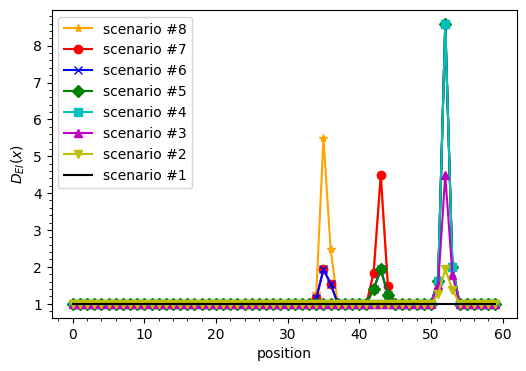

In [54]:
print("File saved in: ", path)
with open(os.path.join(path, 'H_EI_actual.txt'), 'w') as f:
  for case_ in cases.keys():
    print("\nDamage scenario: ", case_[:-5], file=f)
    for point in range(60):
      print(cases[case_]['H_EI']['H_EI_actual'][point], file=f)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
labels = {list(cases.keys())[i]: f'scenario #{i+1}' for i in range(0,8,1)}
print(labels)
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange']
markers = ['o', 'x', 'D', 's', '^', 'v', '*']
for i, case_ in enumerate(list(cases.keys())[::-1]):
  if case_ == '00_00_00_run1':
    color, marker = 'black', None
  else:
    color, marker = colors[i-1], markers[i-1]
  ax.plot(1/cases[case_]['H_EI']['H_EI_actual'], label=labels[case_],
          color=color, marker=marker)
ax.legend()
ax.minorticks_on()
ax.set_ylabel(r'$D_{EI}(x)$')
ax.set_xlabel('position')
plt.savefig(os.path.join(path, 'DEI.pdf'))


In [27]:

cases.keys()

dict_keys(['00_00_00_run1', '05_00_00_run1', '10_00_00_run1', '13_00_00_run1', '13_05_00_run1', '13_05_05_run1', '13_10_05_run1', '13_10_11_run1'])

# Statistical analysis

### Scan of points with a window

In [28]:
half_length_window = 2*ip.h_d
n_points = len(cases[key]['max_curv']['C'])
window_shape = scipy.signal.windows.gaussian(2*half_length_window+1, 
                                             half_length_window/3) # 3stds
window_shape = window_shape * (2*half_length_window+1) / np.sum(window_shape)
for key in cases.keys():
  window_healthy, window_test = [], []
  for i in range(n_points):
    if half_length_window <= i < n_points-half_length_window:
      window_slice = \
      [i for i in range(i-half_length_window, i+half_length_window+1)]
    elif i < half_length_window:
      window_slice = [i for i in range(0,2*half_length_window+1)]
    else:
      window_slice = [i for i in range(n_points-2*half_length_window-1, n_points)]
    window_healthy.append(cases[key]['max_curv']['C_h_noisy'][window_slice]\
                          * window_shape)
    window_test.append(cases[key]['max_curv']['C'][window_slice]\
                       * window_shape)
  cases[key]['max_curv'].update({'window_healthy': window_healthy,
                                 'window_test': window_test})


### Calculation of mean, variance and covariance

In [29]:
for key in cases.keys():
  # global covariance matrix
  mat = np.vstack([cases[key]['max_curv']['C_h_noisy'],
                   cases[key]['max_curv']['C']])
  cases[key]['max_curv']['global_cov_mat'] = np.cov(mat)
  cases[key]['max_curv']['global_var_healthy'] = cases[key]['max_curv']['global_cov_mat'][0,0]*np.ones(n_points)
  cases[key]['max_curv']['global_var_test'] = cases[key]['max_curv']['global_cov_mat'][1,1]*np.ones(n_points)
  cases[key]['max_curv']['global_covar_test_healthy'] = cases[key]['max_curv']['global_cov_mat'][0,1]*np.ones(n_points)
  # window covariance matrices
  cases[key]['max_curv']['cov_mat'] = n_points*[None]
  cases[key]['max_curv']['var_healthy'] = np.zeros(n_points)
  cases[key]['max_curv']['var_test'] = np.zeros(n_points)
  cases[key]['max_curv']['covar_test_healthy'] = np.zeros(n_points)
  cases[key]['max_curv']['mean_healthy'] = np.zeros(n_points) 
  cases[key]['max_curv']['mean_test'] = np.zeros(n_points)
  for i in range(n_points):
    # cases[key]['max_curv']['mean_healthy'][i] = np.mean(cases[key]['max_curv']['window_healthy'][i])
    cases[key]['max_curv']['mean_healthy'][i] = cases[key]['max_curv']['C_h'][i]
    cases[key]['max_curv']['mean_test'][i] = np.mean(cases[key]['max_curv']['window_test'][i])
    mat = np.vstack([cases[key]['max_curv']['window_healthy'][i],
                     cases[key]['max_curv']['window_test'][i]])
    cases[key]['max_curv']['cov_mat'][i] = np.cov(mat)
    cases[key]['max_curv']['var_healthy'][i] = cases[key]['max_curv']['cov_mat'][i][0,0]
    cases[key]['max_curv']['var_test'][i] = cases[key]['max_curv']['cov_mat'][i][1,1]
    cases[key]['max_curv']['covar_test_healthy'][i] = cases[key]['max_curv']['cov_mat'][i][0,1]


### Calculation of strictly standarized mean, damage localization and damage quantification

In [30]:
threshold = 0.25
for key in cases.keys():
  # SSMD from window covariance
  mu_1 = cases[key]['max_curv']['mean_test']
  mu_2 = cases[key]['max_curv']['mean_healthy']
  sigma2_1 = cases[key]['max_curv']['var_test']
  sigma2_2 = cases[key]['max_curv']['var_healthy']
  sigma_12 = cases[key]['max_curv']['covar_test_healthy']
  cases[key]['max_curv']['MD'] = mu_1 - mu_2
  cases[key]['max_curv']['SMD'] = (mu_1 - mu_2) / \
    np.sqrt(sigma2_1 + sigma2_2)
  cases[key]['max_curv']['SSMD'] = (mu_1 - mu_2) / \
    np.sqrt(sigma2_1 + sigma2_2 - 2*sigma_12)
  # damage quantification
  cases[key]['H_EI'].update({'H_EI_avg': mu_2 / mu_1,
                             'H_EI_avg_loc': mu_2 / mu_1,
                             'H_EI_raw': cases[key]['max_curv']['C_h']/cases[key]['max_curv']['C'],
                             'H_EI_raw_loc': cases[key]['max_curv']['C_h']/cases[key]['max_curv']['C']})
  # damage localization 
  for i in range(n_points):
    if i < half_length_window or i >= n_points-half_length_window:
      cases[key]['H_EI']['H_EI_raw'][i] = np.nan
      cases[key]['H_EI']['H_EI_raw_loc'][i] = np.nan
      cases[key]['H_EI']['H_EI_avg'][i] = np.nan
      cases[key]['H_EI']['H_EI_avg_loc'][i] = np.nan
      cases[key]['max_curv']['MD'][i] = np.nan
      cases[key]['max_curv']['SMD'][i] = np.nan
      cases[key]['max_curv']['SSMD'][i] = np.nan
      cases[key]['max_curv']['mean_test'][i] = np.nan
      cases[key]['max_curv']['mean_healthy'][i] = np.nan
      cases[key]['max_curv']['var_test'][i] = np.nan
      cases[key]['max_curv']['var_healthy'][i] = np.nan
      cases[key]['max_curv']['covar_test_healthy'][i] = np.nan
    if cases[key]['max_curv']['SSMD'][i] > -threshold:
      cases[key]['H_EI']['H_EI_avg_loc'][i] = np.nan
      cases[key]['H_EI']['H_EI_raw_loc'][i] = np.nan
   
    

### Plot of instantaneous curvature and damage identification

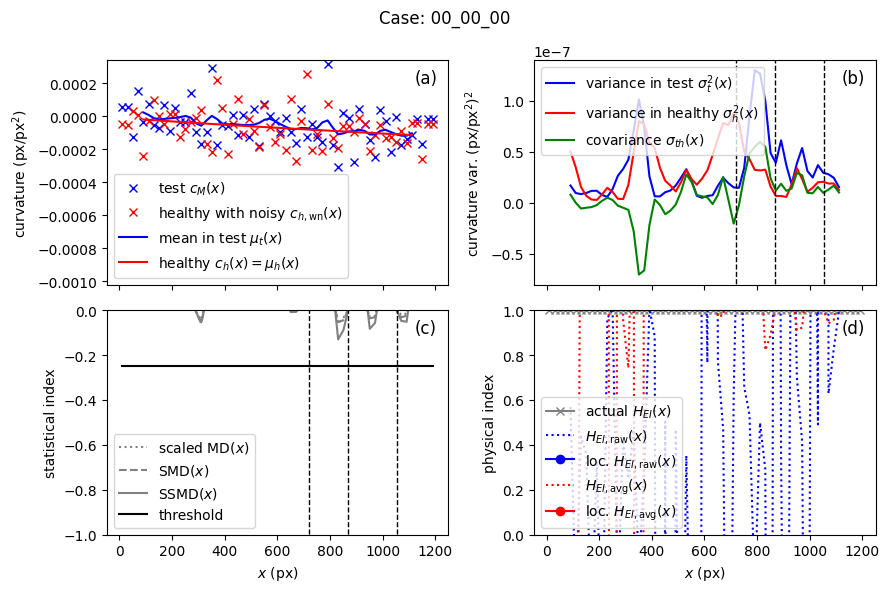

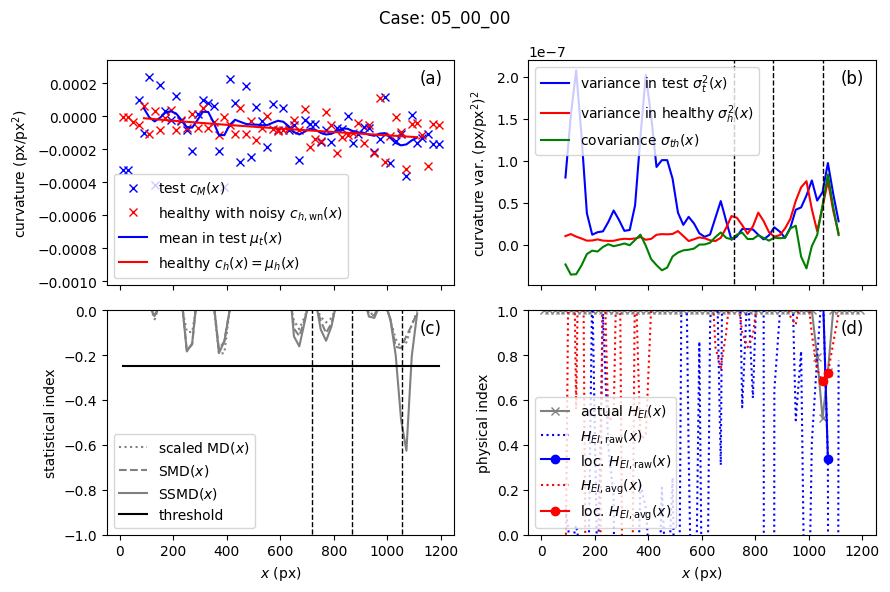

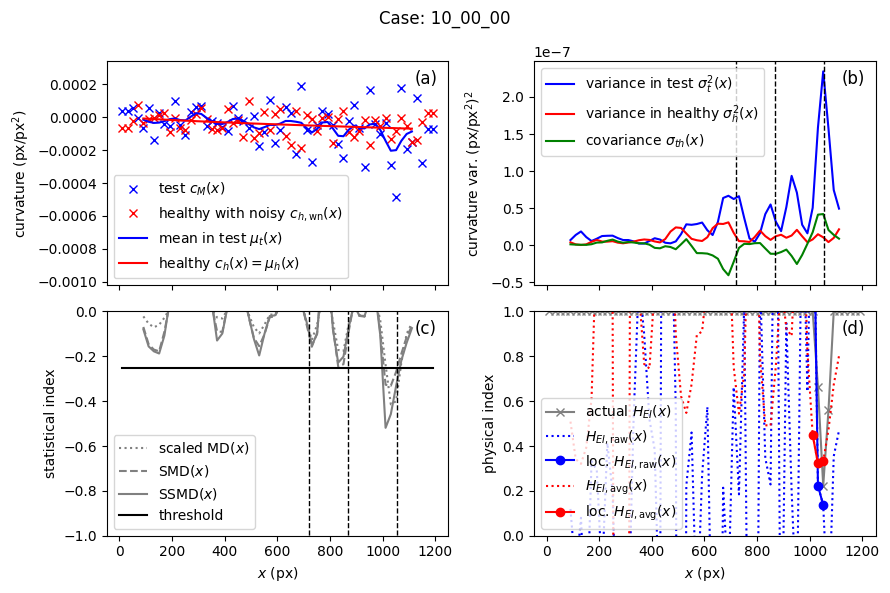

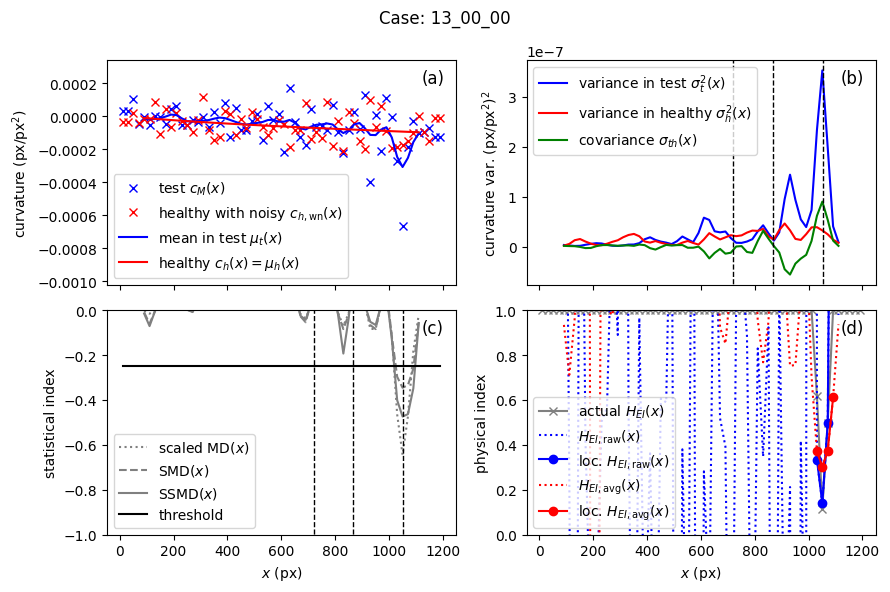

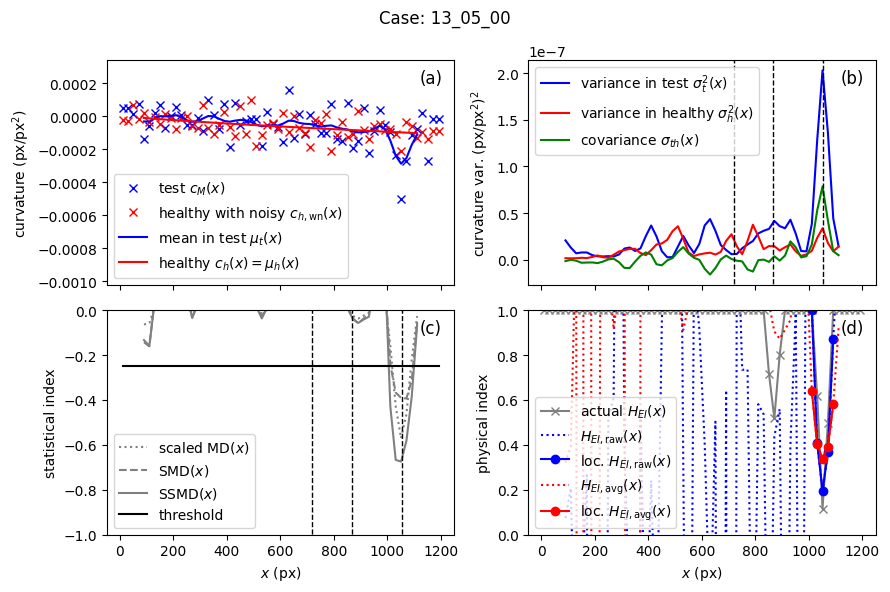

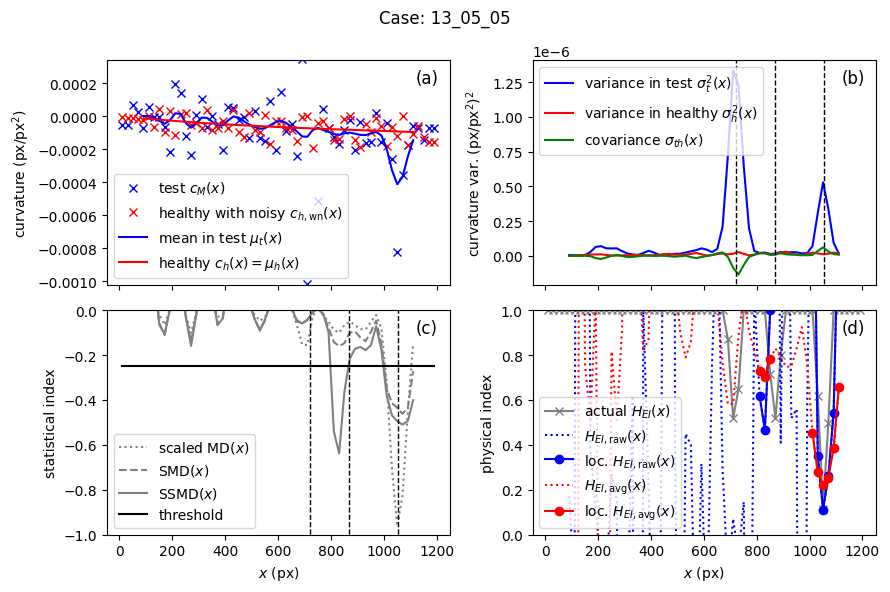

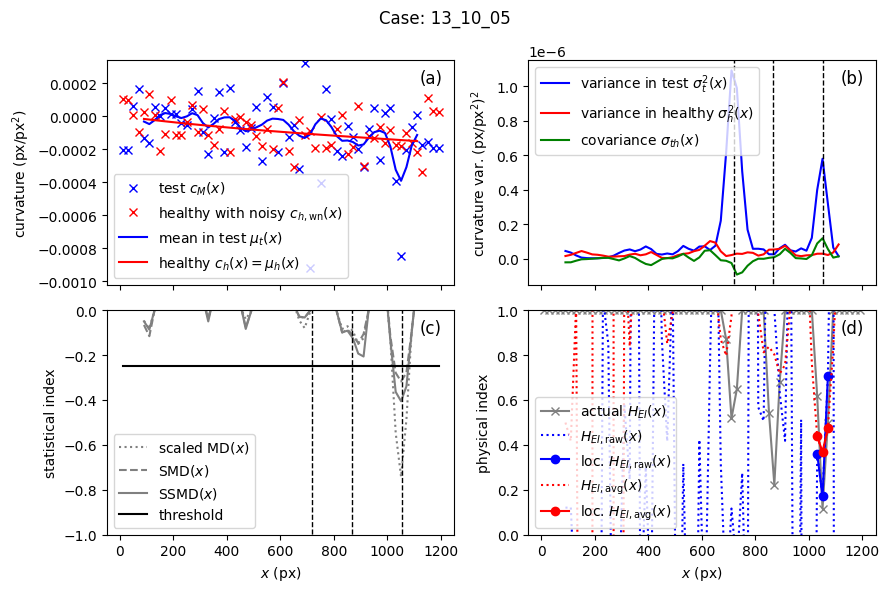

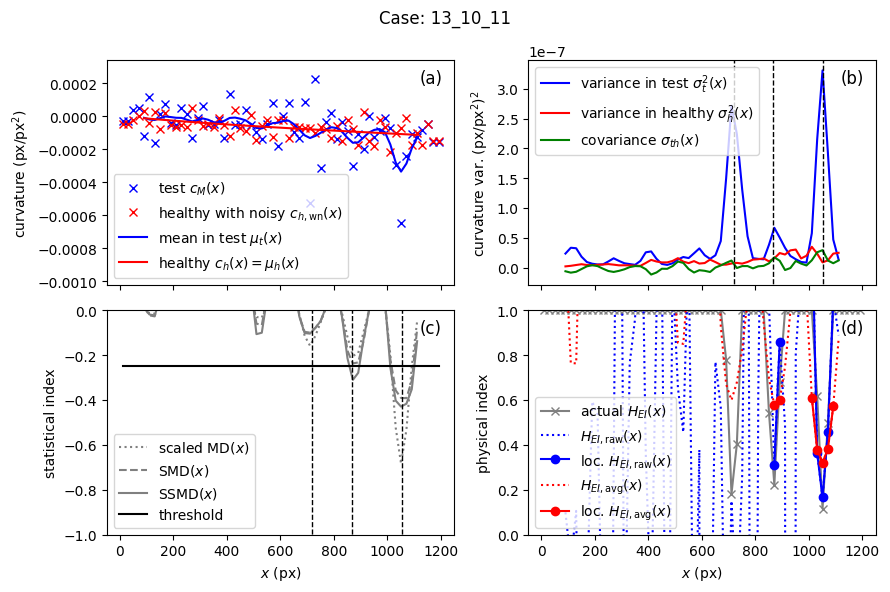

In [31]:
fig_size = (9, 6)
MD_scale = 3000*1
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain'
for key in cases.keys():
  fig, axs = plt.subplots(2,2, figsize=fig_size, sharex=True, tight_layout=True)
  fig.suptitle(f"Case: {key[0:-5]}")  
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C'],
                color='blue', marker='x', linestyle='', label='test $c_M(x)$')
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['C_h_noisy'],
                color='red', marker='x', linestyle='', label='healthy with noisy $c_{h,\mathrm{wn}}(x)$')   
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['mean_test'],
                color='blue', marker='', linestyle='-', label='mean in test $\mu_t(x)$')   
  axs[0,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['mean_healthy'],
                color='red', marker='', linestyle='-', label='healthy $c_h(x)=\mu_h(x)$')   
  axs[0,0].set_ylim((-max_curv_lim, max_curv_lim/3))
  axs[0,0].set_ylabel('curvature (px/px$^2$)')
  axs[0,0].legend(loc='lower left')
  axs[0,0].text(.9, .9, '(a)', fontsize=12, transform=axs[0,0].transAxes)
  # axs[0,0].grid(True)
  axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['var_test'],
              color='blue', label='variance in test $\sigma^2_t(x)$')
  axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['var_healthy'],
              color='red', label='variance in healthy $\sigma^2_h(x)$') 
  axs[0,1].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['covar_test_healthy'],
              color='green', label='covariance $\sigma_{th}(x)$')  
  ylim_ = axs[0,1].get_ylim()
  for loc_px in ip.crack_locs_px:
    axs[0, 1].plot([loc_px, loc_px], [-100, 100],
                   color='black', linewidth=1, linestyle='--', label=None) 
  axs[0,1].set_ylim(ylim_)
  axs[0,1].set_ylabel('curvature var. (px/px$^2$)$^2$')
  axs[0,1].legend(loc='upper left')
  axs[0,1].text(.9, .9, '(b)', fontsize=12, transform=axs[0,1].transAxes)
  # axs[0,1].grid(True) 
  axs[1,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['MD']*MD_scale,
            color='gray', label='scaled $\mathrm{MD}(x)$', linestyle=':') 
  axs[1,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['SMD'],
            color='gray', label='$\mathrm{SMD}(x)$', linestyle='--') 
  axs[1,0].plot(cases[key]['max_curv']['x'], cases[key]['max_curv']['SSMD'],
            color='gray', label='$\mathrm{SSMD}(x)$')  
  axs[1,0].plot(cases[key]['max_curv']['x'], neg_pos*threshold*np.ones(n_points),
            color='black', label='threshold') 
  for loc_px in ip.crack_locs_px:
    axs[1, 0].plot([loc_px, loc_px], [-100, 100],
                   color='black', linewidth=1, linestyle='--', label=None)
  axs[1,0].set_ylabel('statistical index')
  axs[1,0].set_xlabel('$x$ (px)')
  axs[1,0].legend(loc='lower left')
  axs[1,0].set_ylim((-1,0))  
  axs[1,0].text(.9, .9, '(c)', fontsize=12, transform=axs[1,0].transAxes)
  # axs[1,0].grid(True)

  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_actual'],
            color='gray', label='actual $H_{EI}(x)$', marker='x', linestyle='-')   
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_raw'],
            color='blue', label='$H_{EI,\mathrm{raw}}(x)$', linestyle=':')  
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_raw_loc'],
            color='blue', label='loc. $H_{EI,\mathrm{raw}}(x)$', marker='o', linestyle='-')  
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_avg'],
            color='red', label='$H_{EI,\mathrm{avg}}(x)$', linestyle=':')  
  axs[1,1].plot(cases[key]['H_EI']['x'], cases[key]['H_EI']['H_EI_avg_loc'],
            color='red', label='loc. $H_{EI,\mathrm{avg}}(x)$', marker='o', linestyle='-')     
  axs[1,1].set_ylabel('physical index')
  axs[1,1].set_xlabel('$x$ (px)')
  axs[1,1].legend(loc='lower left')
  axs[1,1].set_ylim((0, 1))  
  axs[1,1].text(.9, .9, '(d)', fontsize=12, transform=axs[1,1].transAxes)
  # axs[1,1].set_xlim((600, 1200))  
  # axs[1,1].grid(True)
  plt.savefig(os.path.join(path, f'{key[0:-5]}.pdf'), bbox_inches='tight')
  plt.show()


# Probability Of Detection Analysis

In [32]:
PODA_dict = {}
range_of_points = list(range(4, 56, 8))
print(range_of_points)
for actual_threshold in [1.00, 0.75, 0.5]:
  POD_SSMD, POFA_SSMD = [], []
  POD_SMD, POFA_SMD = [], []
  POD_MD, POFA_MD = [], []
  threshold_s = []
  for threshold_ in np.linspace(-1, 1, 1000):
    TP_SSMD, TN_SSMD, FP_SSMD, FN_SSMD = 0, 0, 0, 0
    TP_SMD, TN_SMD, FP_SMD, FN_SMD = 0, 0, 0, 0  
    TP_MD, TN_MD, FP_MD, FN_MD = 0, 0, 0, 0  
    for key in cases.keys():
      for i, H_EI_actual in enumerate(cases[key]['H_EI']['H_EI_actual']):
        if i in range_of_points:
          if H_EI_actual < actual_threshold:
            if cases[key]['max_curv']['SSMD'][i] < threshold_:
              TP_SSMD += 1
            else:  
              FN_SSMD += 1
            if cases[key]['max_curv']['SMD'][i] < threshold_:
              TP_SMD += 1
            else:  
              FN_SMD += 1 
            if MD_scale*cases[key]['max_curv']['MD'][i] < threshold_:
              TP_MD += 1
            else:  
              FN_MD += 1                        
          else:
            if cases[key]['max_curv']['SSMD'][i] < threshold_:
              FP_SSMD += 1
            else:
              TN_SSMD += 1 
            if cases[key]['max_curv']['SMD'][i] < threshold_:
              FP_SMD += 1
            else:
              TN_SMD += 1    
            if MD_scale*cases[key]['max_curv']['MD'][i] < threshold_:
              FP_MD += 1
            else:
              TN_MD += 1    
    threshold_s.append(threshold_)                             
    POD_SSMD.append(TP_SSMD/(TP_SSMD+FN_SSMD))
    POFA_SSMD.append(FP_SSMD/(FP_SSMD+TN_SSMD))
    POD_SMD.append(TP_SMD/(TP_SMD+FN_SMD))
    POFA_SMD.append(FP_SMD/(FP_SMD+TN_SMD))
    POD_MD.append(TP_MD/(TP_MD+FN_MD))
    POFA_MD.append(FP_MD/(FP_MD+TN_MD))
  POD_SSMD = np.array(POD_SSMD)
  POFA_SSMD = np.array(POFA_SSMD)
  POD_SMD = np.array(POD_SMD)
  POFA_SMD = np.array(POFA_SMD)
  POD_MD = np.array(POD_MD)
  POFA_MD = np.array(POFA_MD)
  PODA_dict.update({actual_threshold: {'threshold_s': threshold_s, 
                                       'POD_SSMD': POD_SSMD, 
                                       'POFA_SSMD': POFA_SSMD, 
                                       'J_SSMD': POD_SSMD - POFA_SSMD,
                                       'POD_SMD': POD_SMD, 
                                       'POFA_SMD': POFA_SMD, 
                                       'J_SMD': POD_SMD - POFA_SMD,
                                       'POD_MD': POD_MD, 
                                       'POFA_MD': POFA_MD,
                                       'J_MD': POD_MD - POFA_MD}})


[4, 12, 20, 28, 36, 44, 52]


In [33]:
# Area under curve
def get_auc(PODA_dict, actual_thresholds):
  AUC_dict = {'MD': {}, 'SMD': {}, 'SSMD': {}}
  for actual_threshold in actual_thresholds:
    POD_SSMD = PODA_dict[actual_threshold]['POD_SSMD']
    POFA_SSMD = PODA_dict[actual_threshold]['POFA_SSMD']
    POD_SMD = PODA_dict[actual_threshold]['POD_SMD']
    POFA_SMD = PODA_dict[actual_threshold]['POFA_SMD']
    POD_MD = PODA_dict[actual_threshold]['POD_MD']
    POFA_MD = PODA_dict[actual_threshold]['POFA_MD']  
    AUC_dict['MD'].update({actual_threshold: np.trapz(y=POD_MD, x=POFA_MD)})
    AUC_dict['SMD'].update({actual_threshold: np.trapz(y=POD_SMD, x=POFA_SMD)})
    AUC_dict['SSMD'].update({actual_threshold: np.trapz(y=POD_SSMD, x=POFA_SSMD)})
  return AUC_dict

AUC_dict = get_auc(PODA_dict, [1.00, 0.75, 0.5])

print(AUC_dict)

{'MD': {1.0: 0.9132653061224489, 0.75: 0.9071969696969697, 0.5: 0.988338192419825}, 'SMD': {1.0: 0.9234693877551021, 0.75: 0.9204545454545455, 0.5: 0.9795918367346939}, 'SSMD': {1.0: 0.9379251700680271, 0.75: 0.9308712121212122, 0.5: 0.9664723032069971}}


## POD plots

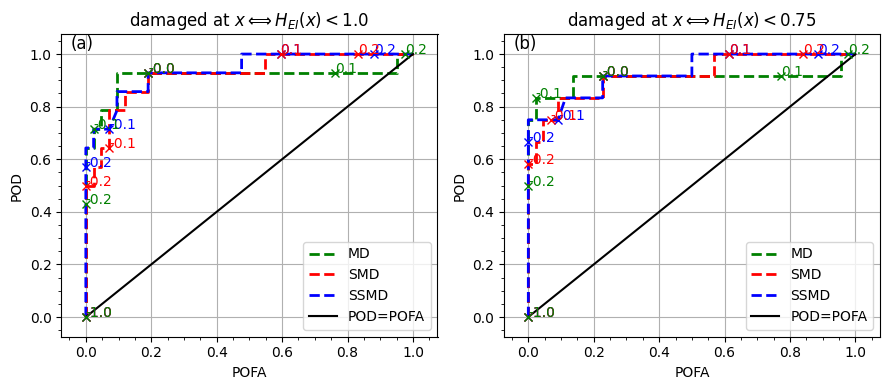

In [34]:
fig_size = (9,4)
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain'
PODA_cases = list(PODA_dict.keys())[0:2]
fig, axs = plt.subplots(1, len(PODA_cases), figsize=fig_size, tight_layout=True)
for i, actual_threshold in enumerate(PODA_cases):
  threshold_s = PODA_dict[actual_threshold]['threshold_s']
  POD_SSMD = PODA_dict[actual_threshold]['POD_SSMD']
  POFA_SSMD = PODA_dict[actual_threshold]['POFA_SSMD']
  POD_SMD = PODA_dict[actual_threshold]['POD_SMD']
  POFA_SMD = PODA_dict[actual_threshold]['POFA_SMD']
  POD_MD = PODA_dict[actual_threshold]['POD_MD']
  POFA_MD = PODA_dict[actual_threshold]['POFA_MD']
  axs[i].set_title('damaged at $x \Longleftrightarrow H_{EI}(x)< $' + f'{actual_threshold}')  
  axs[i].plot(POFA_MD, POD_MD, label='MD', color='green', linestyle='dashed', linewidth=2)
  axs[i].plot(POFA_SMD, POD_SMD, label='SMD', color='red', linestyle='dashed', linewidth=2)
  axs[i].plot(POFA_SSMD, POD_SSMD, label='SSMD', color='blue', linestyle='dashed', linewidth=2)
  axs[i].plot(POFA_MD, POFA_MD, label='POD=POFA', color='black')
  axs[i].set_xlabel('POFA')
  axs[i].set_ylabel('POD')
  axs[i].legend(loc='lower right')
  axs[i].grid()
  some_points = [np.argmin(abs(-1  - np.array(threshold_s))), 
                 np.argmin(abs(-0.1  - np.array(threshold_s))), 
                 np.argmin(abs(-0.2  - np.array(threshold_s))),
                 np.argmin(abs(0   - np.array(threshold_s))), 
                 np.argmin(abs(0.1  - np.array(threshold_s))), 
                 np.argmin(abs(0.2 - np.array(threshold_s)))]
  axs[i].plot(POFA_SSMD[some_points], POD_SSMD[some_points], label='SSMD', color='blue', linestyle='', marker='x')
  axs[i].plot(POFA_SMD[some_points], POD_SMD[some_points], label='SMD', color='red', linestyle='', marker='x')
  axs[i].plot(POFA_MD[some_points], POD_MD[some_points], label='MD', color='green', linestyle='', marker='x')
  axs[i].set_xlim((-.075, 1.075))
  axs[i].set_ylim((-.075, 1.075))
  for i_point in some_points:
    limit = 0
    if POFA_SSMD[i_point] >= limit:
      axs[i].text(POFA_SSMD[i_point], POD_SSMD[i_point], str(np.round(threshold_s[i_point], 2)), color='blue')
    if POFA_SMD[i_point] >= limit:
      axs[i].text(POFA_SMD[i_point], POD_SMD[i_point], str(np.round(threshold_s[i_point], 2)), color='red')
    if POFA_MD[i_point] >= limit:
      axs[i].text(POFA_MD[i_point], POD_MD[i_point], str(np.round(threshold_s[i_point], 2)), color='green')
  # y_ticks = np.linspace(0, 1, 6)#  np.logspace(0.01, 1, 6)
  # y_ticks_labels = [f'{int(_ * 100)}%' for _ in y_ticks]
  # axs[i].set_yticks(y_ticks)
  # axs[i].set_yticklabels(y_ticks_labels)
  axs[i].text(.025, .95, f"({chr(ord('a')+i)})", fontsize=12, transform=axs[i].transAxes)
  axs[i].xaxis.set_minor_locator(AutoMinorLocator())
  axs[i].yaxis.set_minor_locator(AutoMinorLocator())
plt.savefig(os.path.join(path, 'PODA.pdf'), bbox_inches='tight')

In [35]:
TP_SSMD+FN_SSMD

7

In [36]:
TN_SSMD+FP_SSMD

49

# Informedness

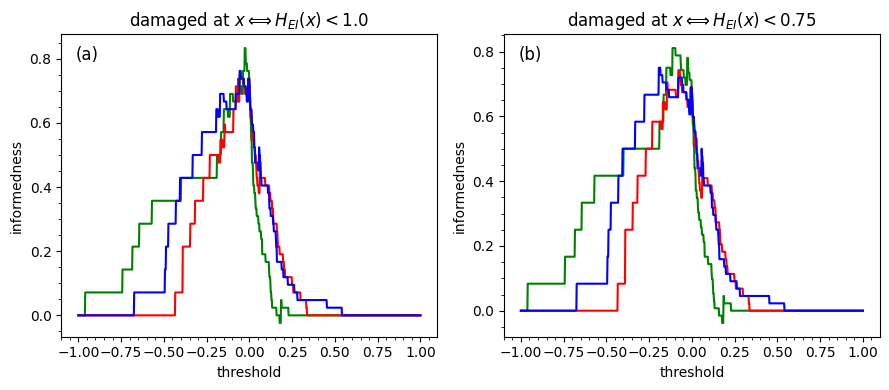

In [37]:
fig_size = (9,4)
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain'
PODA_cases = list(PODA_dict.keys())[0:2]
fig_J, axs_J = plt.subplots(1, len(PODA_cases), figsize=fig_size, tight_layout=True)
for i, actual_threshold in enumerate(PODA_cases):
  threshold_s = PODA_dict[actual_threshold]['threshold_s']
  POD_SSMD = PODA_dict[actual_threshold]['POD_SSMD']
  POFA_SSMD = PODA_dict[actual_threshold]['POFA_SSMD']
  POD_SMD = PODA_dict[actual_threshold]['POD_SMD']
  POFA_SMD = PODA_dict[actual_threshold]['POFA_SMD']
  POD_MD = PODA_dict[actual_threshold]['POD_MD']
  POFA_MD = PODA_dict[actual_threshold]['POFA_MD']
  J_MD = POD_MD - POFA_MD
  J_SMD = POD_SMD - POFA_SMD
  J_SSMD = POD_SSMD - POFA_SSMD
  axs_J[i].set_title('damaged at $x \Longleftrightarrow H_{EI}(x)< $' + f'{actual_threshold}')  
  axs_J[i].plot(threshold_s, J_MD, label='MD', color='green')
  axs_J[i].plot(threshold_s, J_SMD, label='SMD', color='red')
  axs_J[i].plot(threshold_s, J_SSMD, label='SSMD', color='blue')
  axs_J[i].text(.025, .9, f"({chr(ord('a')+i)})", fontsize=12, transform=axs[i].transAxes)
  axs_J[i].set_xlabel('threshold')
  axs_J[i].set_ylabel('informedness')
  axs_J[i].xaxis.set_minor_locator(AutoMinorLocator())
  axs_J[i].yaxis.set_minor_locator(AutoMinorLocator())



# POD and Informedness plots

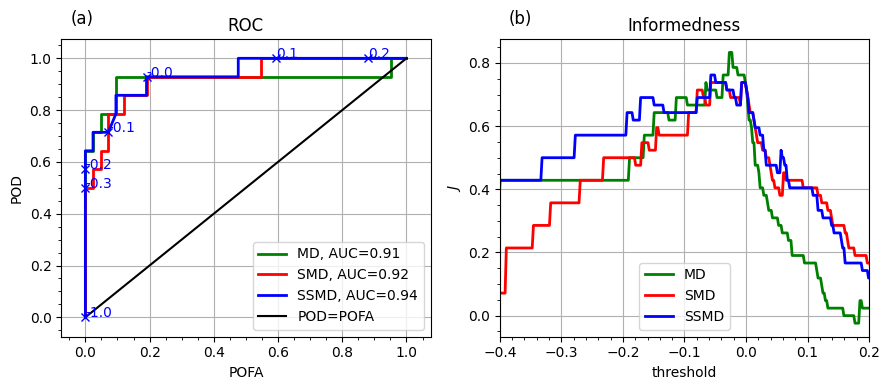

In [38]:
def plot_PODA_J(PODA_dict, AUC_dict, file_name):  
  fig_size = (9,4)
  path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain'
  PODA_cases = list(PODA_dict.keys())[0:2]
  fig, axs = plt.subplots(1, 2, figsize=fig_size, tight_layout=True)

  i = 0
  actual_threshold = PODA_cases[0]
  threshold_s = PODA_dict[actual_threshold]['threshold_s']
  POD_SSMD = PODA_dict[actual_threshold]['POD_SSMD']
  POFA_SSMD = PODA_dict[actual_threshold]['POFA_SSMD']
  POD_SMD = PODA_dict[actual_threshold]['POD_SMD']
  POFA_SMD = PODA_dict[actual_threshold]['POFA_SMD']
  POD_MD = PODA_dict[actual_threshold]['POD_MD']
  POFA_MD = PODA_dict[actual_threshold]['POFA_MD']
  axs[i].set_title('ROC')  
  axs[i].plot(POFA_MD, POD_MD, 
              label=f"MD, AUC={round(AUC_dict['MD'][actual_threshold],2)}", 
              color='green', linestyle='-', linewidth=2)
  axs[i].plot(POFA_SMD, POD_SMD, 
              label=f"SMD, AUC={round(AUC_dict['SMD'][actual_threshold],2)}", 
              color='red', linestyle='-', linewidth=2)
  axs[i].plot(POFA_SSMD, POD_SSMD, 
              label=f"SSMD, AUC={round(AUC_dict['SSMD'][actual_threshold],2)}", 
              color='blue', linestyle='-', linewidth=2)
  axs[i].plot(POFA_MD, POFA_MD, label='POD=POFA', color='black')
  axs[i].set_xlabel('POFA')
  axs[i].set_ylabel('POD')
  axs[i].legend(loc='lower right')
  axs[i].grid(True)
  some_points = [np.argmin(abs(-1   - np.array(threshold_s))), 
                np.argmin(abs(-0.3 - np.array(threshold_s))),
                np.argmin(abs(-0.2 - np.array(threshold_s))),
                np.argmin(abs(-0.1 - np.array(threshold_s))),
                np.argmin(abs(0    - np.array(threshold_s))), 
                np.argmin(abs(0.1  - np.array(threshold_s))),
                np.argmin(abs(0.2  - np.array(threshold_s)))]
  axs[i].plot(POFA_SSMD[some_points], POD_SSMD[some_points], label='SSMD', color='blue', linestyle='', marker='x')
  # axs[i].plot(POFA_SMD[some_points], POD_SMD[some_points], label='SMD', color='red', linestyle='', marker='x')
  # axs[i].plot(POFA_MD[some_points], POD_MD[some_points], label='MD', color='green', linestyle='', marker='x')
  axs[i].set_xlim((-.075, 1.075))
  axs[i].set_ylim((-.075, 1.075))
  for i_point in some_points:
    limit = 0
    if POFA_SSMD[i_point] >= limit:
      axs[i].text(POFA_SSMD[i_point], POD_SSMD[i_point], str(np.round(threshold_s[i_point], 2)), color='blue')
    # if POFA_SMD[i_point] >= limit:
    #   axs[i].text(POFA_SMD[i_point], POD_SMD[i_point], str(np.round(threshold_s[i_point], 2)), color='red')
    # if POFA_MD[i_point] >= limit:
    #   axs[i].text(POFA_MD[i_point], POD_MD[i_point], str(np.round(threshold_s[i_point], 2)), color='green')
  axs[i].text(.025, 1.05, f"({chr(ord('a')+i)})", fontsize=12, transform=axs[i].transAxes)
  axs[i].xaxis.set_minor_locator(AutoMinorLocator())
  axs[i].yaxis.set_minor_locator(AutoMinorLocator())

  i = 1
  threshold_s = PODA_dict[actual_threshold]['threshold_s']
  axs[i].grid(True)
  axs[i].set_title('Informedness')  
  axs[i].plot(threshold_s, PODA_dict[actual_threshold]['J_MD'], 
              label=f"MD", 
              color='green', linestyle='-', linewidth=2)
  axs[i].plot(threshold_s, PODA_dict[actual_threshold]['J_SMD'], 
              label='SMD', 
              color='red', linestyle='-', linewidth=2)
  axs[i].plot(threshold_s, PODA_dict[actual_threshold]['J_SSMD'], 
              label='SSMD', 
              color='blue', linestyle='-', linewidth=2)
  axs[i].text(.025, 1.05, f"({chr(ord('a')+i)})", fontsize=12, transform=axs[i].transAxes)
  axs[i].set_xlabel('threshold')
  axs[i].set_ylabel('$J$')
  axs[i].set_xlim((-.4, .2))
  axs[i].xaxis.set_minor_locator(AutoMinorLocator())
  axs[i].yaxis.set_minor_locator(AutoMinorLocator())
  axs[i].legend(loc='lower center')

  plt.savefig(os.path.join(path, file_name), bbox_inches='tight')

plot_PODA_J(PODA_dict, AUC_dict, 'PODA_J.pdf')  

# Cross validation

## Functions

In [39]:
def perform_poda(samples):
  PODA_dict = {}
  actual_threshold = 1.00
  POD_SSMD, POFA_SSMD = [], []
  POD_SMD, POFA_SMD = [], []
  POD_MD, POFA_MD = [], []
  threshold_s = []
  for threshold_ in np.linspace(-1, 1, 1000):
    TP_SSMD, TN_SSMD, FP_SSMD, FN_SSMD = 0, 0, 0, 0
    TP_SMD, TN_SMD, FP_SMD, FN_SMD = 0, 0, 0, 0  
    TP_MD, TN_MD, FP_MD, FN_MD = 0, 0, 0, 0  
    for key in cases.keys():
      for i, H_EI_actual in enumerate(cases[key]['H_EI']['H_EI_actual']):
        if i in range_of_points: 
          if (key, i) in samples:
            if H_EI_actual < actual_threshold:
              if cases[key]['max_curv']['SSMD'][i] < threshold_:
                TP_SSMD += 1
              else:  
                FN_SSMD += 1
              if cases[key]['max_curv']['SMD'][i] < threshold_:
                TP_SMD += 1
              else:  
                FN_SMD += 1 
              if MD_scale*cases[key]['max_curv']['MD'][i] < threshold_:
                TP_MD += 1
              else:  
                FN_MD += 1                        
            else:
              if cases[key]['max_curv']['SSMD'][i] < threshold_:
                FP_SSMD += 1
              else:
                TN_SSMD += 1 
              if cases[key]['max_curv']['SMD'][i] < threshold_:
                FP_SMD += 1
              else:
                TN_SMD += 1    
              if MD_scale*cases[key]['max_curv']['MD'][i] < threshold_:
                FP_MD += 1
              else:
                TN_MD += 1    
    threshold_s.append(threshold_)                             
    POD_SSMD.append(TP_SSMD/(TP_SSMD+FN_SSMD))
    POFA_SSMD.append(FP_SSMD/(FP_SSMD+TN_SSMD))
    POD_SMD.append(TP_SMD/(TP_SMD+FN_SMD))
    POFA_SMD.append(FP_SMD/(FP_SMD+TN_SMD))
    POD_MD.append(TP_MD/(TP_MD+FN_MD))
    POFA_MD.append(FP_MD/(FP_MD+TN_MD))
  POD_SSMD = np.array(POD_SSMD)
  POFA_SSMD = np.array(POFA_SSMD)
  POD_SMD = np.array(POD_SMD)
  POFA_SMD = np.array(POFA_SMD)
  POD_MD = np.array(POD_MD)
  POFA_MD = np.array(POFA_MD)
  PODA_dict.update({actual_threshold: {'threshold_s': threshold_s, 
                                      'POD_SSMD': POD_SSMD, 
                                      'POFA_SSMD': POFA_SSMD, 
                                      'J_SSMD': POD_SSMD - POFA_SSMD,
                                      'POD_SMD': POD_SMD, 
                                      'POFA_SMD': POFA_SMD, 
                                      'J_SMD': POD_SMD - POFA_SMD,
                                      'POD_MD': POD_MD, 
                                      'POFA_MD': POFA_MD,
                                      'J_MD': POD_MD - POFA_MD}})
  return PODA_dict


## Perform

In [40]:
from itertools import product
import random as rnd

# fraction of samples retained for cross validation
cross_val_frac = 0.50 
actual_threshold = 1.00
n_run = 100

samples_full = list(product(cases.keys(), range_of_points))

opt_J = {'MD': {'max_J': [], 'val_J': []},
         'SMD': {'max_J': [], 'val_J': []},
         'SSMD': {'max_J': [], 'val_J': []},}
for i_run in range(n_run):
  rnd.shuffle(samples_full)
  samples_val = samples_full[0:round(cross_val_frac*len(samples_full))]
  samples_train = samples_full[round(cross_val_frac*len(samples_full)):]
  PODA_dict_train, PODA_dict_val = perform_poda(samples_train), perform_poda(samples_val)
  # threshold optimization
  th_opt_ind = np.argmax(PODA_dict_train[actual_threshold]['J_MD'])
  opt_J['MD']['max_J'].append(PODA_dict_train[actual_threshold]['J_MD'][th_opt_ind])
  opt_J['MD']['val_J'].append(PODA_dict_val[actual_threshold]['J_MD'][th_opt_ind])
  th_opt_ind = np.argmax(PODA_dict_train[actual_threshold]['J_SMD'])
  opt_J['SMD']['max_J'].append(PODA_dict_train[actual_threshold]['J_SMD'][th_opt_ind])
  opt_J['SMD']['val_J'].append(PODA_dict_val[actual_threshold]['J_SMD'][th_opt_ind])
  th_opt_ind = np.argmax(PODA_dict_train[actual_threshold]['J_SSMD'])
  opt_J['SSMD']['max_J'].append(PODA_dict_train[actual_threshold]['J_SSMD'][th_opt_ind])
  opt_J['SSMD']['val_J'].append(PODA_dict_val[actual_threshold]['J_SSMD'][th_opt_ind])  
  # plot_PODA_J(PODA_dict_train, get_auc(PODA_dict_train, [actual_threshold]), 'PODA_J_train.pdf')
  # plot_PODA_J(PODA_dict_val, get_auc(PODA_dict_val, [actual_threshold]), 'PODA_J_val.pdf')  



## Plots

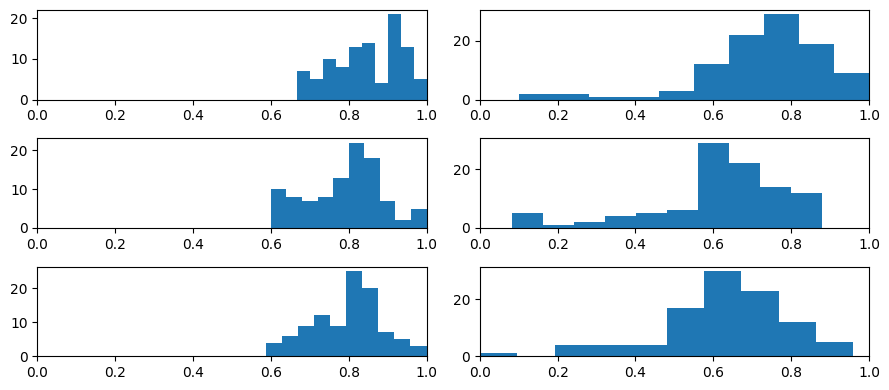

In [41]:
fig_size = (9,4)
path = '/content/drive/My Drive/TRABAJO/45_full_field/Colab Notebooks/Full field time-domain'
PODA_cases = list(PODA_dict.keys())[0:2]
fig, axs = plt.subplots(3, 2, figsize=fig_size, tight_layout=True)

axs[0,0].hist(opt_J['MD']['max_J'])
axs[0,1].hist(opt_J['MD']['val_J'])
axs[1,0].hist(opt_J['SMD']['max_J'])
axs[1,1].hist(opt_J['SMD']['val_J'])
axs[2,0].hist(opt_J['SSMD']['max_J'])
axs[2,1].hist(opt_J['SSMD']['val_J'])
for i in [0, 1, 2]:
  for j in [0, 1]:
    axs[i,j].set_xlim((0,1))
